# Import Libraries

In [38]:
import os



In [39]:
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import optimizers
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, Activation, Dropout, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
tf.config.list_physical_devices('GPU')
gpus = tf.config.list_physical_devices('GPU')
if gpus:
  # Restrict TensorFlow to only use the first GPU
  try:
    tf.config.set_logical_device_configuration(
        gpus[0],
        [tf.config.LogicalDeviceConfiguration(memory_limit=2048)])
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Virtual devices must be set before GPUs have been initialized
    print(e)


# Exploratory Data Analysis

In [40]:
ROOT = "../../dataset_nounknown/"
SEED = 88
IMG_SIZE = (224, 224)    # load at original size first
BATCH_SIZE = 128
LABEL_MODE = "categorical" # one‑hot labels straight away
AUTOTUNE = tf.data.AUTOTUNE

classes=["broccoli", "cauliflower"]
splits=["test", "train", "validate"]

def load_split(split):
    dataset=tf.keras.preprocessing.image_dataset_from_directory(ROOT+split,
        seed        = SEED,
        image_size  = IMG_SIZE,
        batch_size  = BATCH_SIZE,
        label_mode  = LABEL_MODE)
    return dataset

train_ds_pre = load_split("train")
val_ds_pre = load_split("validate")
test_ds_pre = load_split("test")
train_ds_pre=train_ds_pre.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds_pre=val_ds_pre.cache().prefetch(buffer_size=AUTOTUNE)

Found 6518 files belonging to 2 classes.
Found 964 files belonging to 2 classes.
Found 2158 files belonging to 2 classes.


,broccoli,cauliflower,splits total
test,1090,1068,2158
train,3355,3163,6518
validate,493,471,964
img total,4938,4702,9640


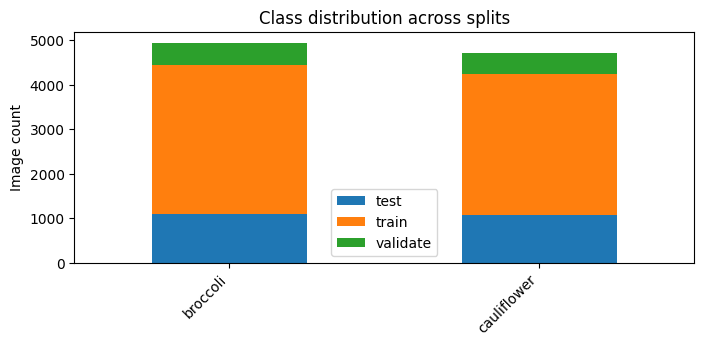

In [41]:
def count_images(split):
    return {cls: len(os.listdir(f"{ROOT}{split}/{cls}/"))
            for cls in classes}

df_counts = pd.DataFrame({s: count_images(s) for s in splits})

table_df = df_counts.T
table_df["splits total"] = table_df.sum(1)
table_df.loc["img total"] = table_df.sum(0)

display(table_df)  # Jupyter table

ax = df_counts.plot.bar(stacked=True, figsize=(8,3))
ax.set_title("Class distribution across splits")
ax.set_ylabel("Image count")
plt.xticks(rotation=45, ha="right")
plt.show()

2025-07-14 18:44:23.302478: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:165: Filling up shuffle buffer (this may take a while): 38 of 1000
2025-07-14 18:44:26.848770: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:482] Shuffle buffer filled.
2025-07-14 18:44:26.852324: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 77071360 bytes after encountering the first element of size 77071360 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


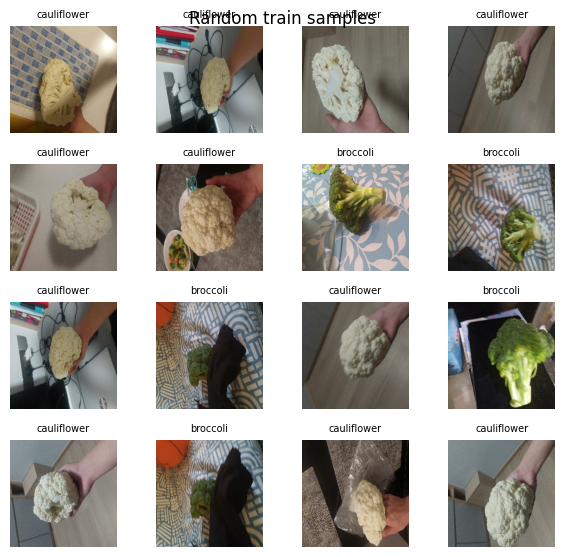

In [42]:
plt.figure(figsize=(6,6))
for images, labels in train_ds_pre.take(1):
    for i in range(16):
        ax = plt.subplot(4,4,i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(classes[np.argmax(labels[i])], fontsize=7)
        plt.axis("off")
plt.suptitle("Random train samples", y=0.92)
plt.tight_layout()
plt.show()

# Data Preprocessing

In [43]:
TARGET_SIZE = 100

resize_and_rescale = tf.keras.Sequential([
    layers.Resizing(TARGET_SIZE, TARGET_SIZE),
    layers.Rescaling(1./255)
])

data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.3),
    layers.RandomTranslation(0.1, 0.1),
    layers.RandomZoom((0.3), 0.3),
])

AUTOTUNE = tf.data.AUTOTUNE

def prepare(ds, shuffle=False, augment=False):
    # Resize and rescale all datasets.
    ds = ds.map(lambda x, y: (resize_and_rescale(x), y), 
                num_parallel_calls=AUTOTUNE)

    if shuffle:
        ds = ds.shuffle(1000)

    # Use data augmentation only on the training set.
    if augment:
        ds = ds.map(lambda x, y: (data_augmentation(x, training=True), y), 
                    num_parallel_calls=AUTOTUNE)

    # Use buffered prefetching on all datasets.
    return ds

train_ds = prepare(train_ds_pre, shuffle=True, augment=True)
val_ds = prepare(val_ds_pre)
test_ds = prepare(test_ds_pre)

2025-07-14 18:44:28.587107: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 15361024 bytes after encountering the first element of size 15361024 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


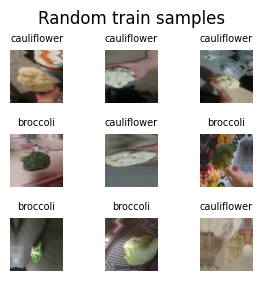

In [44]:
plt.figure(figsize=(3,3))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3,3,i+1)
        plt.imshow((images[i].numpy() * 255).astype("uint8"))
        plt.title(classes[np.argmax(labels[i])], fontsize=7)
        plt.axis("off")

plt.suptitle("Random train samples", y=0.92)
plt.tight_layout()
plt.show()

# Model building

In [45]:
num_classes = 2

model = keras.Sequential()

model.add(layers.Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=(TARGET_SIZE,TARGET_SIZE, 3)))
model.add(layers.BatchNormalization())
model.add(layers.Conv2D(32, (3, 3), padding='same', activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.Dropout(0.25))

model.add(layers.Conv2D(64, (3, 3), padding='same', activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.Conv2D(64, (3, 3), padding='same', activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.Dropout(0.25))

model.add(layers.Conv2D(128, (3, 3), padding='same', activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.Conv2D(128, (3, 3), padding='same', activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.Dropout(0.4))

model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.5))

model.add(layers.Dense(num_classes, activation='softmax'))  # 2 outputs for multi-label
model.summary()


model.summary()

Optimizer = optimizers.Adam(0.001)
model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=Optimizer,
              metrics=['accuracy'])


/home/me/anaconda3/envs/HELP/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_28 (Conv2D)              │ (None, 100, 100, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_33          │ (None, 100, 100, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_29 (Conv2D)              │ (None, 100, 100, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_34          │ (None, 100, 100, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_14 (MaxPooling2D) │ (None, 50, 50, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_19 (Dropout)            │ (None, 50, 50, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_30 (Conv2D)              │ (None, 50, 50, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_35          │ (None, 50, 50, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_31 (Conv2D)              │ (None, 50, 50, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_36          │ (None, 50, 50, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_15 (MaxPooling2D) │ (None, 25, 25, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_20 (Dropout)            │ (None, 25, 25, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_32 (Conv2D)              │ (None, 25, 25, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_37          │ (None, 25, 25, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_33 (Conv2D)              │ (None, 25, 25, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_38          │ (None, 25, 25, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_16 (MaxPooling2D) │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_21 (Dropout)            │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_5 (Flatten)             │ (None, 18432)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 128)            │     2,359,424 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_39          │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 2,648,994 (10.11 MB)

 Trainable params: 2,647,842 (10.10 MB)

 Non-trainable params: 1,152 (4.50 KB)

Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_28 (Conv2D)              │ (None, 100, 100, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_33          │ (None, 100, 100, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_29 (Conv2D)              │ (None, 100, 100, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_34          │ (None, 100, 100, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_14 (MaxPooling2D) │ (None, 50, 50, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_19 (Dropout)            │ (None, 50, 50, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_30 (Conv2D)              │ (None, 50, 50, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_35          │ (None, 50, 50, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_31 (Conv2D)              │ (None, 50, 50, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_36          │ (None, 50, 50, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_15 (MaxPooling2D) │ (None, 25, 25, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_20 (Dropout)            │ (None, 25, 25, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_32 (Conv2D)              │ (None, 25, 25, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_37          │ (None, 25, 25, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_33 (Conv2D)              │ (None, 25, 25, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_38          │ (None, 25, 25, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_16 (MaxPooling2D) │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_21 (Dropout)            │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_5 (Flatten)             │ (None, 18432)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 128)            │     2,359,424 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_39          │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 2,648,994 (10.11 MB)

 Trainable params: 2,647,842 (10.10 MB)

 Non-trainable params: 1,152 (4.50 KB)

In [46]:
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [47]:
history = model.fit(
    train_ds,
    epochs=20,
    verbose=1,
    validation_data = val_ds,
)

score = model.evaluate(test_ds, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])


model.save_weights('model.weights.h5')
tf.keras.models.save_model(model,'model.h5')

Epoch 1/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 77s 1s/step - accuracy: 0.9038 - loss: 0.2746 - val_accuracy: 0.4886 - val_loss: 5.0304
Epoch 2/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 67s 1s/step - accuracy: 0.9962 - loss: 0.0148 - val_accuracy: 0.4886 - val_loss: 6.0279
Epoch 3/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 67s 1s/step - accuracy: 0.9935 - loss: 0.0171 - val_accuracy: 0.4886 - val_loss: 6.3500
Epoch 4/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 67s 1s/step - accuracy: 0.9976 - loss: 0.0117 - val_accuracy: 0.4886 - val_loss: 12.8760
Epoch 5/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 67s 1s/step - accuracy: 0.9968 - loss: 0.0096 - val_accuracy: 0.4886 - val_loss: 6.0486
Epoch 6/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 67s 1s/step - accuracy: 0.9962 - loss: 0.0135 - val_accuracy: 0.4959 - val_loss: 2.9664
Epoch 7/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 67s 1s/step - accuracy: 0.9986 - loss: 0.0070 - val_accuracy: 0.5135 - val_loss: 4.5168
Epoch 8/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 67s 1s/step - accuracy: 0.9985 - loss: 0.0046 - val_accuracy: 0.5851 - val_loss

# Model Evalutation

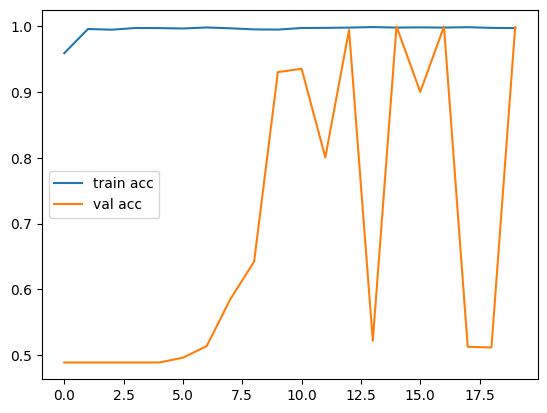

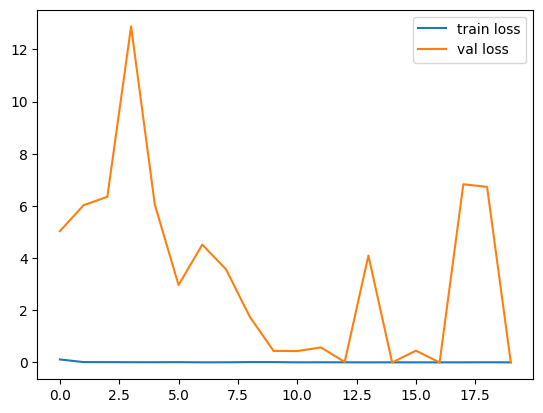

In [50]:
pd.DataFrame(history.history).to_csv("hist.csv", index=False)

plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.legend()
plt.show()